# Optimize and Evaluate Image Generation Models

| Component | Details |
|-----------|---------|
| **Goal** | Demonstrate a standard workflow for optimizing and evaluating an image generation model |
| **Model** | [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1) |
| **Dataset** | [nannullna/laion_subset](https://huggingface.co/datasets/nannullna/laion_subset) |
| **Libraries** | [diffusers](https://github.com/huggingface/diffusers) |
| **Optimization Algorithms** | cacher(deepcache), compiler(torch_compile), quantizer(hqq_diffusers) |
| **Evaluation Metrics** | `elapsed_time`, `lpips`, `ssim`, `psnr`, `clip_score` |

## Getting Started

### Install the Dependencies

To install the dependencies, run the following command:

In [1]:
!pip install pruna

### Set the Device

The device is set to the best available option to maximize the benefits of the optimization process.

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

## Load the Model

Before optimizing the model, we first ensure that it loads correctly and fits into memory. For this example, we will use a lightweight image generation model, [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1), but feel free to use any [text-to-image model on Hugging Face](https://huggingface.co/models?pipeline_tag=text-to-image).

Although Pruna works at least as good with smaller models, a small model is a good starting point to show the steps of the optimization process.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.bfloat16)
pipe = pipe.to(device)

Now that we've loaded the pipeline, let's examine some of the outputs it can generate. We use an example from [this amazing prompt guide](https://strikingloo.github.io/stable-diffusion-vs-dalle-2).

  0%|          | 0/50 [00:00<?, ?it/s]

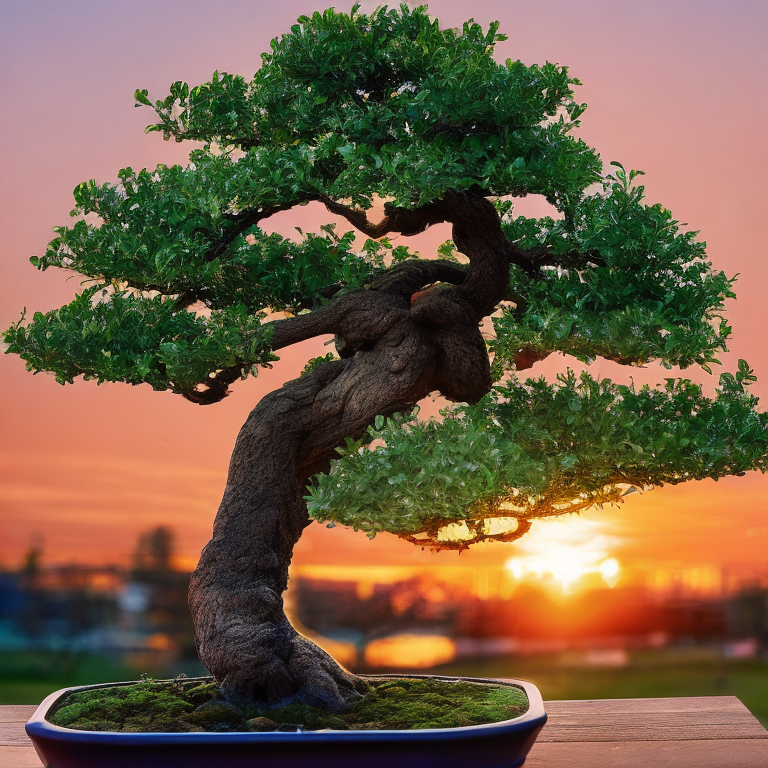

In [4]:
prompt = "Editorial Style Photo, Bonsai Apple Tree, Task Lighting, Inspiring and Sunset, Afternoon, Beautiful, 4k"
image = pipe(
    prompt,
    generator=torch.Generator().manual_seed(42),
)
image.images[0]

As we can see, the model is able to generate a beautiful image based on the provided input prompt.

## Define the SmashConfig

Now that we've confirmed the model is functioning correctly, let's proceed with the optimization process by defining the `SmashConfig`, which will be used later to optimize the model.

For diffusion models, the most important categories of optimization algorithms are cachers, compilers, and quantizers. Note that not all algorithms are compatible with every model. For Stable Diffusion models, the following options are available:

<img src="../assets/images/stable_diffusion_algorithms.png" alt="Stable Diffusion Algorithms" height="100"/>

You can learn more about the various optimization algorithms and their hyperparameters in the [Algorithms Overview](https://docs.pruna.ai/en/stable/compression.html) section of the documentation.

In this optimization, we'll combine [``deepcache``](https://docs.pruna.ai/en/stable/compression.html#deepcache), [``torch_compile``](https://docs.pruna.ai/en/stable/compression.html#torch-compile), and [`hqq-diffusers`](https://docs.pruna.ai/en/stable/compression.html#hqq-diffusers). We'll also update some of the parameters for these algorithms, setting `hqq_diffusers_weight_bits` to `4`. This is just one of many possible configurations and is intended to serve as an example.

<img src="../assets/images/stable_diffusion_quantized.png" alt="Stable Diffusion Algorithms" height="100"/>

Let's define the `SmashConfig` object.

In [5]:
from pruna import SmashConfig

smash_config = SmashConfig(device=device)
# configure the deepcache cacher
smash_config["cacher"] = "deepcache"
smash_config["deepcache_interval"] = 2
# configure the torch_compile compiler
smash_config["compiler"] = "torch_compile"
# configure the hqq_diffusers quantizer
smash_config["quantizer"] = "hqq_diffusers"
smash_config["hqq_diffusers_weight_bits"] = 4
smash_config["hqq_diffusers_group_size"] = 64
smash_config["hqq_diffusers_backend"] = "marlin"

## Smash the Model

Now that we've defined the `SmashConfig` object, we can proceed to smash the model. We'll use the `smash` function, passing both the `model` and the `smash_config` as arguments. We make a deep copy of the model to avoid modifying the original model.

Let's smash the model, which should take around 20 seconds for this configuration.

In [6]:
import copy

from pruna import smash

copy_pipe = copy.deepcopy(pipe)
smashed_pipe = smash(
    model=copy_pipe,
    smash_config=smash_config,
)

INFO - Starting quantizer hqq_diffusers...
100%|██████████| 216/216 [00:00<00:00, 374.42it/s]
INFO - quantizer hqq_diffusers was applied successfully.
INFO - Starting cacher deepcache...
INFO - cacher deepcache was applied successfully.
INFO - Starting compiler torch_compile...
self.unet=None of type <class 'NoneType'> cannot be saved.
INFO - compiler torch_compile was applied successfully.


Now that we've smashed the model, let's verify that everything still works as expected by running inference with the smashed model.

  0%|          | 0/50 [00:00<?, ?it/s]

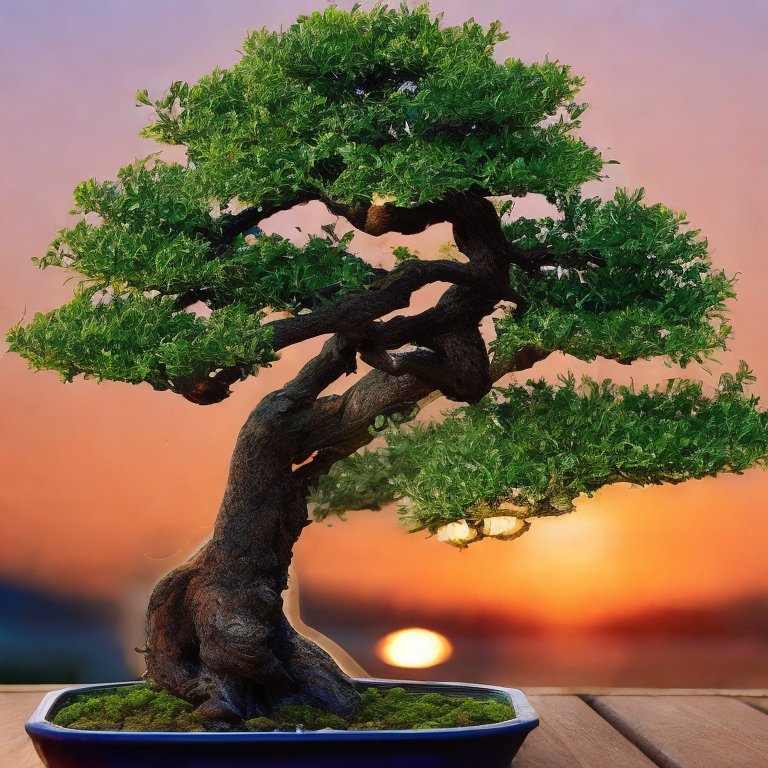

In [7]:
prompt = "Editorial Style Photo, Bonsai Apple Tree, Task Lighting, Inspiring and Sunset, Afternoon, Beautiful, 4k"
image = smashed_pipe(
    prompt,
    generator=torch.Generator().manual_seed(42),
)
image.images[0]

As we can see, the model is able to generate a similar image as the original model. 

If you notice a significant difference, it might have several reasons, the model, the configuration, the hardware, etc. As optimization can be non-deterministic, we encourage you to retry the optimization process or try out different configurations and models to find the best fit for your use case but also feel free to reach out to us on [Discord](https://discord.gg/Tun8YgzxZ9) if you have any questions or feedback.

## Evaluate the Smashed Model

Now that the model has been optimized, we can evaluate its performance using the `EvaluationAgent`. This evaluation will include metrics like `elapsed_time` for general performance and the `lpips`, `ssim`, `psnr`, and `clip_score` for evaluating the quality of the generated images.

You can find a complete overview of all available metrics in our [documentation](https://docs.pruna.ai/).

In [ ]:
from pruna import PrunaModel
from pruna.data.pruna_datamodule import PrunaDataModule
from pruna.evaluation.evaluation_agent import EvaluationAgent
from pruna.evaluation.metrics import (
    LatencyMetric,
    TorchMetricWrapper,
)
from pruna.evaluation.task import Task

# Define the metrics
metrics = [
    LatencyMetric(device=device, n_iterations=2, n_warmup_iterations=1, timing_type="async"),
    *[TorchMetricWrapper(metric) for metric in ["lpips", "ssim", "psnr", "clip_score"]]
]

# Define the datamodule
datamodule = PrunaDataModule.from_string("LAION256")
datamodule.limit_datasets(10)

# Define the task and evaluation agent
task = Task(metrics, datamodule=datamodule, device=device)
eval_agent = EvaluationAgent(task)

# Evaluate base model, and smashed model
wrapped_pipe = PrunaModel(model=pipe)
base_model_results = eval_agent.evaluate(wrapped_pipe)
smashed_model_results = eval_agent.evaluate(smashed_pipe)

We can now review the evaluation results and compare the performance of the original model with the optimized version.

In [11]:
def get_metric_result(results, metric_name):  # noqa: D103
    for result in results:
        if result.name == metric_name:
            return result
    return None


# Calculate percentage differences for each metric
def calculate_percentage_diff(original, optimized):  # noqa: D103
    return ((optimized - original) / original) * 100


# Calculate and display percentage differences
print("Percentage differences between original and optimized model:")
for result in base_model_results:
    metric_name = result.name
    smashed_result = get_metric_result(smashed_model_results, metric_name)
    diff = calculate_percentage_diff(result.result, smashed_result.result)
    print(f"{metric_name}: {diff:.2f}%")

Percentage differences between original and optimized model:
clip_score: -3.99%
latency: -47.35%


As we can see, the optimized model is approximately 2× faster and smaller than the base model. While the CLIP score remains nearly unchanged, the fidelity metrics (LPIPS, SSIM, and PSNR) indicate slight differences in output quality. This is expected, given the nature of the optimization process.

We can now save the optimized model to disk or share it with others:

In [ ]:
# save the model to disk
smashed_pipe.save_pretrained("stable-diffusion-2-1-smashed")
# after saving the model, you can load it with
# smashed_pipe = PrunaModel.from_pretrained("stable-diffusion-2-1-smashed")

# save the model to HuggingFace
# smashed_pipe.save_to_hub("PrunaAI/stable-diffusion-2-1-smashed")
# smashed_pipe = PrunaModel.from_hub("PrunaAI/stable-diffusion-2-1-smashed")

## Conclusion

In this tutorial, we demonstrated a standard workflow for optimizing and evaluating an image generation model using Pruna.

We defined our optimization strategy using the `SmashConfig` object and applied it to the model with the `smash` function. We then evaluated the performance of the optimized model using the `EvaluationAgent`, comparing key metrics such as `elapsed_time`, `CLIP score`, and fidelity measures like `LPIPS`, `SSIM`, and `PSNR`.

To support the workflow, we also used the `PrunaDataModule` to load the dataset and the `Task` object to configure the task and link it to the evaluation process.

The results show that we can significantly improve runtime performance and reduce memory usage and energy consumption, while maintaining a high level of output quality. This makes it easy to explore trade-offs and iterate on configurations to find the best optimization strategy for your specific use case.